In [58]:
# from google.colab import drive
# drive.mount('/content/drive')

In [59]:
import tensorflow as tf

# Pastikan menggunakan session dengan benar jika menggunakan TensorFlow 1.x
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


### Import libs

In [60]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

In [61]:
from keras import backend as K

# Untuk pelatihan
K.set_learning_phase(1)

#### Config setting

In [62]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False


		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1, 1], [1, 1]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 300

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None
        max_anchor_size = 120

		self.model_path = None

#### Parser the data from annotation file

In [63]:
def get_data(input_path):
	"""Parse the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
    
	all_imgs = {}

	classes_count = {}  

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [64]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Vgg-16 model

In [65]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

####  RPN layer

In [66]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

####  Classifier layer

In [67]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

#### Calculate IoU (Intersection of Union)

In [68]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [69]:
  from sklearn.cluster import KMeans
  import cv2
  import numpy as np
  import random

  def divide_image_into_grids(image, grid_size):
      h, w = image.shape[:2]
      grids = []
      for y in range(0, h, grid_size):
          for x in range(0, w, grid_size):
              grids.append(image[y:y+grid_size, x:x+grid_size])
      return grids

  def calculate_histograms(grids):
      histograms = []
      for grid in grids:
          hist_b = cv2.calcHist([grid], [0], None, [256], [0, 256])
          hist_g = cv2.calcHist([grid], [1], None, [256], [0, 256])
          hist_r = cv2.calcHist([grid], [2], None, [256], [0, 256])
          hist = np.concatenate((hist_b, hist_g, hist_r)).flatten()
          histograms.append(hist)
      return histograms

  def cluster_histograms(histograms, n_clusters=1):
      kmeans = KMeans(n_clusters=n_clusters)
      kmeans.fit(histograms)
      return kmeans.labels_, kmeans.cluster_centers_

  def form_anchor_boxes(labels, grid_size, image_shape, n_clusters):
      anchor_boxes = []
      h, w = image_shape[:2]
      n_grids_x = w // grid_size
      n_grids_y = h // grid_size

      

      for cluster_id in range(n_clusters):
          indices = np.where(labels == cluster_id)[0]
          if len(indices) == 0:
              continue
          xs = indices % n_grids_x
          ys = indices // n_grids_x
          x_min = np.min(xs) * grid_size
          x_max = np.max(xs) * grid_size
          y_min = np.min(ys) * grid_size
          y_max = np.max(ys) * grid_size

          # Memastikan ukuran anchor box tidak melebihi maksimal yang diizinkan
          width = min(x_max - x_min, max_anchor_size)
          height = min(y_max - y_min, max_anchor_size)

          # Menghitung x_min dan y_min baru berdasarkan width dan height yang disesuaikan
          x_min = (x_min + x_max - width) // 2
          y_min = (y_min + y_max - height) // 2
          x_max = x_min + width
          y_max = y_min + height

          anchor_boxes.append((x_min, y_min, x_max, y_max))
      return anchor_boxes

  def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):

      downscale = float(C.rpn_stride)
      anchor_sizes = C.anchor_box_scales
      anchor_ratios = C.anchor_box_ratios
      num_anchors = len(anchor_sizes) * len(anchor_ratios)

      # calculate the output map size based on the network architecture
      (output_width, output_height) = img_length_calc_function(resized_width, resized_height)
      n_anchratios = len(anchor_ratios)

      # Grid-based histogram processing
      grid_size = 10  # Example grid size
      grids = divide_image_into_grids(cv2.resize(cv2.imread(img_data['filepath']), (resized_width, resized_height)), grid_size)
      histograms = calculate_histograms(grids)
      labels, _ = cluster_histograms(histograms, n_clusters=num_anchors)
      anchor_boxes = form_anchor_boxes(labels, grid_size, (resized_height, resized_width), num_anchors)

      # Initialise empty output objectives
      y_rpn_overlap = np.zeros((output_height, output_width, num_anchors)).astype(int)
      y_is_box_valid = np.zeros((output_height, output_width, num_anchors)).astype(int)
      y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

      num_bboxes = len(img_data['bboxes'])

      num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
      best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
      best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
      best_x_for_bbox = np.zeros((num_bboxes, 4))
      best_dx_for_bbox = np.zeros((num_bboxes, 4))

      # Get the GT box coordinates, and resize to account for image resizing
      gta = np.zeros((num_bboxes, 4))
      for bbox_num, bbox in enumerate(img_data['bboxes']):
          gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
          gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
          gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
          gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))

      # RPN ground truth
      for anchor_idx, anchor in enumerate(anchor_boxes):
          x1_anc, y1_anc, x2_anc, y2_anc = anchor

          ix = int((x1_anc + x2_anc) / 2 / downscale)
          jy = int((y1_anc + y2_anc) / 2 / downscale)

          if ix < 0 or ix >= output_width or jy < 0 or jy >= output_height:
              continue

          # bbox_type indicates whether an anchor should be a target
          bbox_type = 'neg'

          # this is the best IOU for the (x,y) coord and the current anchor
          # note that this is different from the best IOU for a GT bbox
          best_iou_for_loc = 0.0

          for bbox_num in range(num_bboxes):
              curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])

              if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                  cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                  cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                  cxa = (x1_anc + x2_anc) / 2.0
                  cya = (y1_anc + y2_anc) / 2.0

                  tx = (cx - cxa) / (x2_anc - x1_anc)
                  ty = (cy - cya) / (y2_anc - y1_anc)
                  tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                  th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

              if img_data['bboxes'][bbox_num]['class'] != 'bg':
                  if curr_iou > best_iou_for_bbox[bbox_num]:
                      best_anchor_for_bbox[bbox_num] = [jy, ix, 0, anchor_idx]
                      best_iou_for_bbox[bbox_num] = curr_iou
                      best_x_for_bbox[bbox_num, :] = [x1_anc, x2_anc, y1_anc, y2_anc]
                      best_dx_for_bbox[bbox_num, :] = [tx, ty, tw, th]

                  if curr_iou > C.rpn_max_overlap:
                      bbox_type = 'pos'
                      num_anchors_for_bbox[bbox_num] += 1
                      if curr_iou > best_iou_for_loc:
                          best_iou_for_loc = curr_iou
                          best_regr = (tx, ty, tw, th)

                  if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                      if bbox_type != 'pos':
                          bbox_type = 'neutral'

          if bbox_type == 'neg':
              y_is_box_valid[jy, ix, anchor_idx] = 1
              y_rpn_overlap[jy, ix, anchor_idx] = 0
          elif bbox_type == 'neutral':
              y_is_box_valid[jy, ix, anchor_idx] = 0
              y_rpn_overlap[jy, ix, anchor_idx] = 0
          elif bbox_type == 'pos':
              y_is_box_valid[jy, ix, anchor_idx] = 1
              y_rpn_overlap[jy, ix, anchor_idx] = 1
              start = 4 * anchor_idx
              y_rpn_regr[jy, ix, start:start+4] = best_regr

      for bbox_num in range(num_bboxes):
          if num_anchors_for_bbox[bbox_num] == 0:
              if best_anchor_for_bbox[bbox_num, 0] == -1:
                  continue
              y_is_box_valid[best_anchor_for_bbox[bbox_num, 0], best_anchor_for_bbox[bbox_num, 1], best_anchor_for_bbox[bbox_num, 3]] = 1
              y_rpn_overlap[best_anchor_for_bbox[bbox_num, 0], best_anchor_for_bbox[bbox_num, 1], best_anchor_for_bbox[bbox_num, 3]] = 1
              start = 4 * best_anchor_for_bbox[bbox_num, 3]
              y_rpn_regr[best_anchor_for_bbox[bbox_num, 0], best_anchor_for_bbox[bbox_num, 1], start:start+4] = best_dx_for_bbox[bbox_num, :]

      y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
      y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)
      y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
      y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)
      y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
      y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

      pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
      neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

      num_pos = len(pos_locs[0])
      num_regions = 256

      if len(pos_locs[0]) > num_regions//2:
          val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions//2)
          y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
          num_pos = num_regions//2

      if len(neg_locs[0]) + num_pos > num_regions:
          val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) + num_pos - num_regions)
          y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

      y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
      y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

      return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos


#### Get new image size and augment the image

In [70]:
import copy
import cv2

def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data
	
	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:	
		# Convert the image to YUV color space
		img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
		
		# Apply histogram equalization to the Y channel
		img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
		
		# Increase the contrast by scaling up the Y channel
		img_yuv[:, :, 0] = cv2.multiply(img_yuv[:, :, 0], 0.4)
		img_yuv[:, :, 0] = cv2.min(img_yuv[:, :, 0], 255)  # Ensure pixel values are within [0, 255]
		
		# Convert the YUV image back to BGR format
		img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img


#### Generate the ground_truth anchors

In [71]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)

	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

#### Define loss functions for all four outputs

In [72]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

In [73]:
def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])

    return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [74]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list

    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
    """Apply regression layer to all anchors in one feature map

    Args:
        X: shape=(4, 18, 25) the current anchor type for all points in the feature map
        T: regression layer shape=(4, 18, 25)

    Returns:
        X: regressed position and size for current anchor
    """
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
    try:
        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h

def calc_iou(R, img_data, C, class_mapping):
    """Converts from (x1,y1,x2,y2) to (x,y,w,h) format

    Args:
        R: bboxes, probs
    """
    bboxes = img_data['bboxes']
    (width, height) = (img_data['width'], img_data['height'])
    # get image dimensions for resizing
    (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

    gta = np.zeros((len(bboxes), 4))

    for bbox_num, bbox in enumerate(bboxes):
        # get the GT box coordinates, and resize to account for image resizing
        # gta[bbox_num, 0] = (40 * (600 / 800)) / 16 = int(round(1.875)) = 2 (x in feature map)
        gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
        gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
        gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

    x_roi = []
    y_class_num = []
    y_class_regr_coords = []
    y_class_regr_label = []
    IoUs = [] # for debugging only

    # R.shape[0]: number of bboxes (=300 from non_max_suppression)
    for ix in range(R.shape[0]):
        (x1, y1, x2, y2) = R[ix, :]
        x1 = int(round(x1))
        y1 = int(round(y1))
        x2 = int(round(x2))
        y2 = int(round(y2))

        best_iou = 0.0
        best_bbox = -1
        # Iterate through all the ground-truth bboxes to calculate the iou
        for bbox_num in range(len(bboxes)):
            curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])

            # Find out the corresponding ground-truth bbox_num with larget iou
            if curr_iou > best_iou:
                best_iou = curr_iou
                best_bbox = bbox_num

        if best_iou < C.classifier_min_overlap:
                continue
        else:
            w = x2 - x1
            h = y2 - y1
            x_roi.append([x1, y1, w, h])
            IoUs.append(best_iou)

            if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
                # hard negative example
                cls_name = 'bg'
            elif C.classifier_max_overlap <= best_iou:
                cls_name = bboxes[best_bbox]['class']
                cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
                cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

                cx = x1 + w / 2.0
                cy = y1 + h / 2.0

                tx = (cxg - cx) / float(w)
                ty = (cyg - cy) / float(h)
                tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
                th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
            else:
                print('roi = {}'.format(best_iou))
                raise RuntimeError

        class_num = class_mapping[cls_name]
        class_label = len(class_mapping) * [0]
        class_label[class_num] = 1
        y_class_num.append(copy.deepcopy(class_label))
        coords = [0] * 4 * (len(class_mapping) - 1)
        labels = [0] * 4 * (len(class_mapping) - 1)
        if cls_name != 'bg':
            label_pos = 4 * class_num
            sx, sy, sw, sh = C.classifier_regr_std
            coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
            labels[label_pos:4+label_pos] = [1, 1, 1, 1]
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))
        else:
            y_class_regr_coords.append(copy.deepcopy(coords))
            y_class_regr_label.append(copy.deepcopy(labels))

    if len(x_roi) == 0:
        return None, None, None, None

    # bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
    X = np.array(x_roi)
    # one hot code for bboxes from above => x_roi (X)
    Y1 = np.array(y_class_num)
    # corresponding labels and corresponding gt bboxes
    Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

    return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

In [75]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 18) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 72) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 18) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



### Start training

In [76]:
base_path = r'E:\TA_2324_20\TRAIN SIDANG\model_revisi\\'


train_path =  r'E:\TA_2324_20\Training annotation_normalized.txt'

num_rois = 4 # Number of RoIs to process at once.

         
output_weight_path = os.path.join(base_path, 'model_GBHfrcnn_vgg.hdf5')

record_path = os.path.join(base_path, 'record.csv') # Record data (used to save the losses, classification accuracy and mean average precision)

base_weight_path = r'E:/TA_2324_20/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

config_output_filename = os.path.join(base_path, 'GBH_config.pickle')

In [77]:
import os
print(os.path.exists(base_weight_path ))  # Harusnya True jika file ada


True


In [78]:
# Create the config
C = Config()



C.record_path = record_path
C.model_path = output_weight_path
C.num_rois = num_rois

C.base_net_weights = base_weight_path

In [79]:
#--------------------------------------------------------#
# This step will spend some time to load the data        #
#--------------------------------------------------------#
st = time.time()
train_imgs, classes_count, class_mapping = get_data(train_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files
idx=1233
Spend 1.01 mins to load the data


In [80]:
if 'bg' not in classes_count:
	classes_count['bg'] = 0
	class_mapping['bg'] = len(class_mapping)
# e.g.
#    classes_count: {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745, 'bg': 0}
#    class_mapping: {'Person': 0, 'Car': 1, 'Mobile phone': 2, 'bg': 3}
C.class_mapping = class_mapping

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))
print(class_mapping)

# Save the configuration
with open(config_output_filename, 'wb') as config_f:
	pickle.dump(C,config_f)
	print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))


Training images per class:
{'bg': 0, 'face': 1233}
Num classes (including bg) = 2
{'face': 0, 'bg': 1}
Config has been written to E:\TA_2324_20\TRAIN SIDANG\model_revisi\\GBH_config.pickle, and can be loaded when testing to ensure correct results


In [81]:
# Shuffle the images with seed
random.seed(1)
random.shuffle(train_imgs)

print('Num train samples (images) {}'.format(len(train_imgs)))

Num train samples (images) 1185


In [82]:
# Get train data generator which generate X, Y, image_data
data_gen_train = get_anchor_gt(train_imgs, C, get_img_output_length, mode='train')

#### Explore 'data_gen_train'

data_gen_train is an **generator**, so we get the data by calling **next(data_gen_train)**

In [83]:
X, Y, image_data, debug_img, debug_num_pos = next(data_gen_train)

Original image: height=4032 width=3024
Resized image:  height=400 width=300 C.im_size=300
Feature map size: height=25 width=18 C.rpn_stride=16
(1, 400, 300, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 25, 18, 18)
Shape of y_rpn_regr (1, 25, 18, 72)
{'filepath': 'E:\\TA_2324_20\\Anotation - Terbaru\\Anotasi 22-Terbaru\\Dataset SI 22.v3i.tensorflow\\train\\Jonathan_SI_22_png.rf.1bd0cd2f1b2157570cbf04143d031c56.jpg', 'width': 3024, 'height': 4032, 'bboxes': [{'class': 'face', 'x1': 1051, 'x2': 1996, 'y1': 736, 'y2': 2044}]}
Number of positive anchors for this image: 1
(array([ 7,  7, 13, 13, 13, 16, 17], dtype=int64), array([ 9,  9,  8,  9,  9,  9, 10], dtype=int64), array([ 4, 13,  8,  0,  2,  3,  7], dtype=int64))
(array([7, 7, 7, 7], dtype=int64), array([9, 9, 9, 9], dtype=int64), array([16, 17, 18, 19], dtype=int64))
y_rpn_cls for possible pos anchor: [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.   

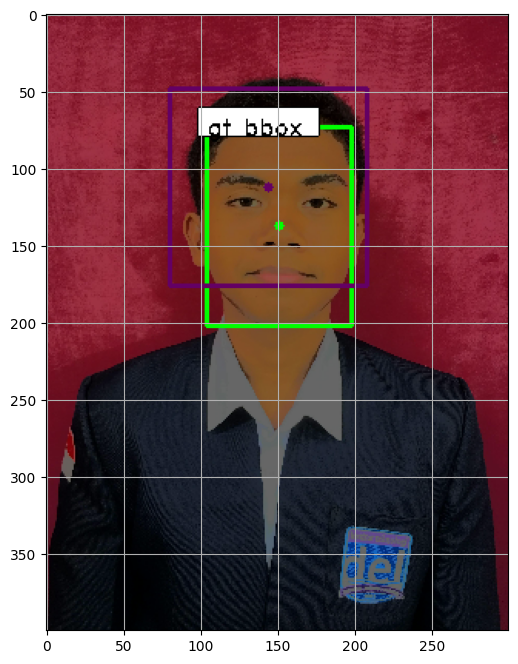

In [84]:
print('Original image: height=%d width=%d'%(image_data['height'], image_data['width']))
print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(Y[0].shape[1], Y[0].shape[2], C.rpn_stride))
print(X.shape)
print(str(len(Y))+" includes 'y_rpn_cls' and 'y_rpn_regr'")
print('Shape of y_rpn_cls {}'.format(Y[0].shape))
print('Shape of y_rpn_regr {}'.format(Y[1].shape))
print(image_data)

print('Number of positive anchors for this image: %d' % (debug_num_pos))
if debug_num_pos==0:
    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['height']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['height'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['width']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['width'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    plt.grid()
    plt.imshow(img)
    plt.show()
else:
    cls = Y[0][0]
    pos_cls = np.where(cls==1)
    print(pos_cls)
    regr = Y[1][0]
    pos_regr = np.where(regr==1)
    print(pos_regr)
    print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
    print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

    gt_x1, gt_x2 = image_data['bboxes'][0]['x1']*(X.shape[2]/image_data['width']), image_data['bboxes'][0]['x2']*(X.shape[2]/image_data['width'])
    gt_y1, gt_y2 = image_data['bboxes'][0]['y1']*(X.shape[1]/image_data['height']), image_data['bboxes'][0]['y2']*(X.shape[1]/image_data['height'])
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    img = debug_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = (0, 255, 0)
    #   cv2.putText(img, 'gt bbox', (gt_x1, gt_y1-5), cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
    cv2.rectangle(img, (gt_x1, gt_y1), (gt_x2, gt_y2), color, 2)
    cv2.circle(img, (int((gt_x1+gt_x2)/2), int((gt_y1+gt_y2)/2)), 3, color, -1)

    # Add text
    textLabel = 'gt bbox'
    (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.5,1)
    textOrg = (gt_x1, gt_y1+5)
    cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 0), 1)

    # Draw positive anchors according to the y_rpn_regr
    for i in range(debug_num_pos):

        color = (100+i*(155/4), 0, 100+i*(155/4))

        idx = pos_regr[2][i*4]/4
        anchor_size = C.anchor_box_scales[int(idx/3)]
        anchor_ratio = C.anchor_box_ratios[2-int((idx+1)%3)]

        center = (pos_regr[1][i*4]*C.rpn_stride, pos_regr[0][i*4]*C.rpn_stride)
        print('Center position of positive anchor: ', center)
        cv2.circle(img, center, 3, color, -1)
        anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
        cv2.rectangle(img, (center[0]-int(anc_w/2), center[1]-int(anc_h/2)), (center[0]+int(anc_w/2), center[1]+int(anc_h/2)), color, 2)
#         cv2.putText(img, 'pos anchor bbox '+str(i+1), (center[0]-int(anc_w/2), center[1]-int(anc_h/2)-5), cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)

print('Green bboxes is ground-truth bbox. Others are positive anchors')
plt.figure(figsize=(8,8))
plt.grid()
plt.imshow(img)
plt.show()

#### Build the model

In [85]:
input_shape_img = (None, None, 3)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

In [86]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios) # 9

rpn = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count))

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

# Because the google colab can only run the session several hours one time (then you need to connect again), 
# we need to save the model and load the model to continue training
if not os.path.isfile(C.model_path):
    #If this is the begin of the training, load the pre-traind base network such as vgg-16
    try:
        print('This is the first time of your training')
        print('loading weights from {}'.format(C.base_net_weights))
        model_rpn.load_weights(C.base_net_weights, by_name=True)
        model_classifier.load_weights(C.base_net_weights, by_name=True)
    except  Exception as e:
        print(f'Error loading weights: {e}')
        print('Could not load pretrained model weights. Weights can be found in the keras application folder \
            https://github.com/fchollet/keras/tree/master/keras/applications')
    
    # Create the record.csv file to record losses, acc and mAP
    record_df = pd.DataFrame(columns=['mean_overlapping_bboxes', 'class_acc', 'loss_rpn_cls', 'loss_rpn_regr', 'loss_class_cls', 'loss_class_regr', 'curr_loss', 'elapsed_time', 'mAP'])
else:
    # If this is a continued training, load the trained model from before
    print('Continue training based on previous trained model')
    print('Loading weights from {}'.format(C.model_path))
    model_rpn.load_weights(C.model_path, by_name=True)
    model_classifier.load_weights(C.model_path, by_name=True)
    
    # Load the records
    record_df = pd.read_csv(record_path)

    r_mean_overlapping_bboxes = record_df['mean_overlapping_bboxes']
    r_class_acc = record_df['class_acc']
    r_loss_rpn_cls = record_df['loss_rpn_cls']
    r_loss_rpn_regr = record_df['loss_rpn_regr']
    r_loss_class_cls = record_df['loss_class_cls']
    r_loss_class_regr = record_df['loss_class_regr']
    r_curr_loss = record_df['curr_loss']
    r_elapsed_time = record_df['elapsed_time']
    r_mAP = record_df['mAP']

    print('Already train %dK batches'% (len(record_df)))

This is the first time of your training
loading weights from E:/TA_2324_20/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5


In [87]:
import os

weights_path = 'E:/TA_2324_20/model/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
print(os.path.exists(weights_path))


True


In [88]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [89]:
# Training setting
total_epochs = len(record_df)
r_epochs = len(record_df)

epoch_length = 32
num_epochs = 1000
iter_num = 0

total_epochs += num_epochs

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []

if len(record_df)==0:
    best_loss = np.Inf
else:
    best_loss = np.min(r_curr_loss)

In [90]:
print(len(record_df))
K.set_learning_phase(1) 

0


In [91]:
from keras import backend as K

# Untuk pelatihan
K.set_learning_phase(1)


In [92]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [93]:
import keras
import tensorflow as tf

keras.backend.set_session(tf.Session())
keras.backend.get_session().run(tf.global_variables_initializer())


<module 'keras' from 'E:\\envs\\TA-2324-20_a\\lib\\site-packages\\keras\\__init__.py'>

In [95]:
start_time = time.time()
for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(r_epochs + 1, total_epochs))
    
    r_epochs += 1

    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
#                 print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

            # Generate X (x_img) and label Y ([y_rpn_cls, y_rpn_regr])
            X, Y, img_data, debug_img, debug_num_pos = next(data_gen_train)

            # Train rpn model and get loss value [_, loss_rpn_cls, loss_rpn_regr]
            loss_rpn = model_rpn.train_on_batch(X, Y)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = model_rpn.predict_on_batch(X)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # Y1: one hot code for bboxes from above => x_roi (X)
            # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data, C, class_mapping)

            # If X2 is None means there are no matching bboxes
            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue
            
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('final_cls', np.mean(losses[:iter_num, 2])), ('final_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Total loss: {}'.format(loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))
                    elapsed_time = (time.time()-start_time)/60

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                new_row = {'mean_overlapping_bboxes':round(mean_overlapping_bboxes, 3), 
                           'class_acc':round(class_acc, 3), 
                           'loss_rpn_cls':round(loss_rpn_cls, 3), 
                           'loss_rpn_regr':round(loss_rpn_regr, 3), 
                           'loss_class_cls':round(loss_class_cls, 3), 
                           'loss_class_regr':round(loss_class_regr, 3), 
                           'curr_loss':round(curr_loss, 3), 
                           'elapsed_time':round(elapsed_time, 3), 
                           'mAP': 0}

                record_df = record_df.append(new_row, ignore_index=True)
                record_df.to_csv(record_path, index=0)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')

Epoch 1/1000
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
32/32 [==============================] - 115s - rpn_cls: 0.6000 - rpn_regr: 0.2977 - final_cls: 0.6724 - final_regr: 0.2627   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 1.8125
Classifier accuracy for bounding boxes from RPN: 0.7265625
Loss RPN classifier: 0.6087633091956377
Loss RPN regression: 0.3188683365006
Loss Detector classifier: 0.6554833459667861
Loss Detector regression: 0.23922991566359997
Total loss: 1.8223449073266238
Elapsed time: 115.4189510345459
Total loss decreased from inf to 1.8223449073266238, saving weights
Epoch 2/1000
32/32 [==============================] - 111s - rpn_cls: 0.5293 - rpn_regr: 0.2964 - final_cls: 0.5666 - final_regr: 0.2762   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 1.875
Classifier accuracy for bounding boxes from RPN: 0.7578125
Loss RPN classifier: 0.4895285

32/32 [==============================] - 109s - rpn_cls: 0.2013 - rpn_regr: 0.1256 - final_cls: 0.1648 - final_regr: 0.1059   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.125
Classifier accuracy for bounding boxes from RPN: 0.9453125
Loss RPN classifier: 0.22669455365394242
Loss RPN regression: 0.13709910932811908
Loss Detector classifier: 0.17147072615625802
Loss Detector regression: 0.10527197041665204
Total loss: 0.6405363595549716
Elapsed time: 109.67406702041626
Epoch 32/1000
32/32 [==============================] - 107s - rpn_cls: 0.1879 - rpn_regr: 0.0689 - final_cls: 0.0764 - final_regr: 0.1153   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.09375
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.137116310208512
Loss RPN regression: 0.09368568225181662
Loss Detector classifier: 0.09713975133490749
Loss Detector regression: 0.11751093209022656
Total loss: 0.44545267588546267
Elapsed time: 107.

32/32 [==============================] - 105s - rpn_cls: 0.2439 - rpn_regr: 0.1644 - final_cls: 0.1590 - final_regr: 0.1085   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.78125
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.12677473771918812
Loss RPN regression: 0.1041567166976165
Loss Detector classifier: 0.12351934125035768
Loss Detector regression: 0.1174311846261844
Total loss: 0.4718819802933467
Elapsed time: 105.42640089988708
Epoch 48/1000
32/32 [==============================] - 109s - rpn_cls: 0.1836 - rpn_regr: 0.0895 - final_cls: 0.1822 - final_regr: 0.1131   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.78125
Classifier accuracy for bounding boxes from RPN: 0.9140625
Loss RPN classifier: 0.13626790329840333
Loss RPN regression: 0.0814539051061729
Loss Detector classifier: 0.21619523262597795
Loss Detector regression: 0.11312835960416123
Total loss: 0.5470454006347154
Elapsed time: 109

32/32 [==============================] - 106s - rpn_cls: 0.1079 - rpn_regr: 0.0544 - final_cls: 0.1576 - final_regr: 0.0944   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.6875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.1344471216580132
Loss RPN regression: 0.07178559461317491
Loss Detector classifier: 0.10755858420088771
Loss Detector regression: 0.08817503676982597
Total loss: 0.4019663372419018
Elapsed time: 106.65543580055237
Total loss decreased from 0.4118996583347325 to 0.4019663372419018, saving weights
Epoch 64/1000
32/32 [==============================] - 109s - rpn_cls: 0.0636 - rpn_regr: 0.0873 - final_cls: 0.2090 - final_regr: 0.1180   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.34375
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.0865414698555469
Loss RPN regression: 0.08272460068110377
Loss Detector classifier: 0.11161847643097644
Loss Detecto

32/32 [==============================] - 107s - rpn_cls: 0.0892 - rpn_regr: 0.0466 - final_cls: 0.1365 - final_regr: 0.1088   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.75
Classifier accuracy for bounding boxes from RPN: 0.9296875
Loss RPN classifier: 0.1388077130691272
Loss RPN regression: 0.07851350281271152
Loss Detector classifier: 0.1500516129854077
Loss Detector regression: 0.10766518459422514
Total loss: 0.47503801346147156
Elapsed time: 107.96882843971252
Epoch 80/1000
32/32 [==============================] - 106s - rpn_cls: 0.1510 - rpn_regr: 0.0500 - final_cls: 0.0576 - final_regr: 0.1184   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.0625
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.13187801804451738
Loss RPN regression: 0.07403584131679963
Loss Detector classifier: 0.05007150176970754
Loss Detector regression: 0.11253613588633016
Total loss: 0.3685214970173547
Elapsed time: 106.

32/32 [==============================] - 106s - rpn_cls: 0.0542 - rpn_regr: 0.0550 - final_cls: 0.2273 - final_regr: 0.1146   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.5625
Classifier accuracy for bounding boxes from RPN: 0.9296875
Loss RPN classifier: 0.050834047676744376
Loss RPN regression: 0.05022453428682638
Loss Detector classifier: 0.1890920004079817
Loss Detector regression: 0.10232461418490857
Total loss: 0.392475196556461
Elapsed time: 106.95786309242249
Epoch 96/1000
32/32 [==============================] - 109s - rpn_cls: 0.0798 - rpn_regr: 0.0532 - final_cls: 0.1129 - final_regr: 0.1027   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.21875
Classifier accuracy for bounding boxes from RPN: 0.9375
Loss RPN classifier: 0.14503153736586682
Loss RPN regression: 0.07326808619836811
Loss Detector classifier: 0.1377577579460194
Loss Detector regression: 0.10128048091428354
Total loss: 0.4573378624245379
Elapsed time: 109.2

32/32 [==============================] - 108s - rpn_cls: 0.0595 - rpn_regr: 0.0423 - final_cls: 0.1493 - final_regr: 0.0848   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.6875
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.11275222588301403
Loss RPN regression: 0.055852275821962394
Loss Detector classifier: 0.11746136809415475
Loss Detector regression: 0.08434883414884098
Total loss: 0.37041470394797216
Elapsed time: 108.09721779823303
Epoch 112/1000
32/32 [==============================] - 105s - rpn_cls: 0.1624 - rpn_regr: 0.0675 - final_cls: 0.0662 - final_regr: 0.1170   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.0625
Classifier accuracy for bounding boxes from RPN: 0.9453125
Loss RPN classifier: 0.08816409396604286
Loss RPN regression: 0.07552390576165635
Loss Detector classifier: 0.11736732732970268
Loss Detector regression: 0.11716785747557878
Total loss: 0.39822318453298067
Elapsed time:

32/32 [==============================] - 109s - rpn_cls: 0.0789 - rpn_regr: 0.0540 - final_cls: 0.1193 - final_regr: 0.1037   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.46875
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.07567728275898844
Loss RPN regression: 0.08118592278333381
Loss Detector classifier: 0.10646852515492355
Loss Detector regression: 0.10842211998533458
Total loss: 0.3717538506825804
Elapsed time: 109.39338421821594
Epoch 128/1000
32/32 [==============================] - 109s - rpn_cls: 0.1924 - rpn_regr: 0.0772 - final_cls: 0.1634 - final_regr: 0.1405   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.28125
Classifier accuracy for bounding boxes from RPN: 0.9453125
Loss RPN classifier: 0.13564358389612607
Loss RPN regression: 0.058238734272890724
Loss Detector classifier: 0.13261524996778462
Loss Detector regression: 0.11039577517658472
Total loss: 0.43689334331338614
Elapsed tim

32/32 [==============================] - 108s - rpn_cls: 0.1409 - rpn_regr: 0.0800 - final_cls: 0.0925 - final_regr: 0.0731   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.28125
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.10732241400546627
Loss RPN regression: 0.06438205944141373
Loss Detector classifier: 0.07461331193189835
Loss Detector regression: 0.07946979440748692
Total loss: 0.32578757978626527
Elapsed time: 108.69877767562866
Epoch 144/1000
32/32 [==============================] - 109s - rpn_cls: 0.0753 - rpn_regr: 0.0613 - final_cls: 0.1623 - final_regr: 0.1044   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.07012461519070712
Loss RPN regression: 0.05280472223239485
Loss Detector classifier: 0.11341033052303828
Loss Detector regression: 0.09601636347360909
Total loss: 0.33235603141974934
Elapsed time: 

32/32 [==============================] - 109s - rpn_cls: 0.0900 - rpn_regr: 0.0508 - final_cls: 0.0616 - final_regr: 0.0935   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.28125
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.09181039045324724
Loss RPN regression: 0.0402250506672317
Loss Detector classifier: 0.05598877576267114
Loss Detector regression: 0.08524918707553297
Total loss: 0.27327340395868305
Elapsed time: 109.06209444999695
Total loss decreased from 0.2746324098452533 to 0.27327340395868305, saving weights
Epoch 160/1000
32/32 [==============================] - 105s - rpn_cls: 0.0720 - rpn_regr: 0.0368 - final_cls: 0.1200 - final_regr: 0.0853   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.15625
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.06532458973742905
Loss RPN regression: 0.037392899408587255
Loss Detector classifier: 0.1127105117411702
Loss D

32/32 [==============================] - 110s - rpn_cls: 0.0872 - rpn_regr: 0.0776 - final_cls: 0.1481 - final_regr: 0.0770   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.0905763568872544
Loss RPN regression: 0.06589598667778773
Loss Detector classifier: 0.07730140054627554
Loss Detector regression: 0.08986900595482439
Total loss: 0.32364275006614207
Elapsed time: 110.30035734176636
Epoch 176/1000
32/32 [==============================] - 108s - rpn_cls: 0.0864 - rpn_regr: 0.0516 - final_cls: 0.0527 - final_regr: 0.0810   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.96875
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.07630820502623692
Loss RPN regression: 0.045446523756254464
Loss Detector classifier: 0.09462962158431765
Loss Detector regression: 0.08066128694918007
Total loss: 0.2970456373159891
Elapsed time:

32/32 [==============================] - 105s - rpn_cls: 0.0911 - rpn_regr: 0.0753 - final_cls: 0.0784 - final_regr: 0.1095   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.15625
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.0782464412718582
Loss RPN regression: 0.04618902358743071
Loss Detector classifier: 0.057650584902148694
Loss Detector regression: 0.09562315157381818
Total loss: 0.2777092013352558
Elapsed time: 105.70542049407959
Epoch 192/1000
32/32 [==============================] - 110s - rpn_cls: 0.0699 - rpn_regr: 0.0424 - final_cls: 0.0978 - final_regr: 0.0746   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.8125
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.04907386698323535
Loss RPN regression: 0.03489465195161756
Loss Detector classifier: 0.12320073010778287
Loss Detector regression: 0.08795786713017151
Total loss: 0.2951271161728073
Elapsed time: 1

32/32 [==============================] - 108s - rpn_cls: 0.0647 - rpn_regr: 0.0350 - final_cls: 0.0914 - final_regr: 0.0878   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.4375
Classifier accuracy for bounding boxes from RPN: 0.9453125
Loss RPN classifier: 0.10930877974260511
Loss RPN regression: 0.04412988435069565
Loss Detector classifier: 0.12091616156794771
Loss Detector regression: 0.08494477538624778
Total loss: 0.35929960104749625
Elapsed time: 108.02206540107727
Epoch 208/1000
32/32 [==============================] - 108s - rpn_cls: 0.1031 - rpn_regr: 0.0499 - final_cls: 0.2031 - final_regr: 0.0779   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.59375
Classifier accuracy for bounding boxes from RPN: 0.9375
Loss RPN classifier: 0.07218064326025342
Loss RPN regression: 0.03862702531478135
Loss Detector classifier: 0.1722127876491868
Loss Detector regression: 0.07343802592367865
Total loss: 0.3564584821479002
Elapsed time: 10

32/32 [==============================] - 105s - rpn_cls: 0.0715 - rpn_regr: 0.0422 - final_cls: 0.1454 - final_regr: 0.0826   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.84375
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.08292584964988237
Loss RPN regression: 0.04242302275315524
Loss Detector classifier: 0.11430893534634379
Loss Detector regression: 0.09003335802117363
Total loss: 0.329691165770555
Elapsed time: 105.64792537689209
Epoch 224/1000
32/32 [==============================] - 108s - rpn_cls: 0.0305 - rpn_regr: 0.0538 - final_cls: 0.0880 - final_regr: 0.0705   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.0
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.06089750461296717
Loss RPN regression: 0.031125082353355538
Loss Detector classifier: 0.052863765908114146
Loss Detector regression: 0.07661084295250475
Total loss: 0.2214971958269416
Elapsed time: 10

32/32 [==============================] - 108s - rpn_cls: 0.1047 - rpn_regr: 0.0578 - final_cls: 0.0573 - final_regr: 0.0650   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.09375
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.0944022481689899
Loss RPN regression: 0.04377388388093095
Loss Detector classifier: 0.041065853871259606
Loss Detector regression: 0.07822392630623654
Total loss: 0.257465912227417
Elapsed time: 108.94325852394104
Epoch 240/1000
32/32 [==============================] - 106s - rpn_cls: 0.0579 - rpn_regr: 0.0297 - final_cls: 0.0917 - final_regr: 0.0931   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.90625
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.05466995070764824
Loss RPN regression: 0.03475056005845545
Loss Detector classifier: 0.10376772391646227
Loss Detector regression: 0.08634507557144389
Total loss: 0.27953331025400985
Elapsed time: 

32/32 [==============================] - 108s - rpn_cls: 0.0368 - rpn_regr: 0.0571 - final_cls: 0.0912 - final_regr: 0.1000   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.875
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.04282650411278155
Loss RPN regression: 0.04074557716376148
Loss Detector classifier: 0.0777052757596266
Loss Detector regression: 0.08776829519774765
Total loss: 0.24904565223391728
Elapsed time: 108.58833837509155
Epoch 256/1000
32/32 [==============================] - 106s - rpn_cls: 0.0380 - rpn_regr: 0.0312 - final_cls: 0.0725 - final_regr: 0.0735   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.03125
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.06046881492920875
Loss RPN regression: 0.03331847154186107
Loss Detector classifier: 0.08244675390778866
Loss Detector regression: 0.0839076786651276
Total loss: 0.2601417190439861
Elapsed time: 106

32/32 [==============================] - 106s - rpn_cls: 0.0568 - rpn_regr: 0.0313 - final_cls: 0.1082 - final_regr: 0.0849   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.59375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.05979603826199309
Loss RPN regression: 0.03216926678214804
Loss Detector classifier: 0.09181146366609028
Loss Detector regression: 0.08462929676170461
Total loss: 0.268406065471936
Elapsed time: 106.57350254058838
Epoch 272/1000
32/32 [==============================] - 106s - rpn_cls: 0.0401 - rpn_regr: 0.0306 - final_cls: 0.0643 - final_regr: 0.0899   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.96875
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.05246785304052537
Loss RPN regression: 0.04130029989028117
Loss Detector classifier: 0.07847374946504715
Loss Detector regression: 0.0867994996951893
Total loss: 0.259041402091043
Elapsed time: 106

32/32 [==============================] - 108s - rpn_cls: 0.1376 - rpn_regr: 0.0329 - final_cls: 0.0498 - final_regr: 0.0746   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.09375
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.08192855169818358
Loss RPN regression: 0.035136848120600916
Loss Detector classifier: 0.1057294110210023
Loss Detector regression: 0.08059589090407826
Total loss: 0.30339070174386507
Elapsed time: 108.8789644241333
Epoch 288/1000
32/32 [==============================] - 107s - rpn_cls: 0.0957 - rpn_regr: 0.0583 - final_cls: 0.0609 - final_regr: 0.0858   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.59375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.10271646521232469
Loss RPN regression: 0.05183532253977319
Loss Detector classifier: 0.07249031243554782
Loss Detector regression: 0.09162371276761405
Total loss: 0.31866581295525975
Elapsed time:

32/32 [==============================] - 110s - rpn_cls: 0.1130 - rpn_regr: 0.0407 - final_cls: 0.0664 - final_regr: 0.0681   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.9375
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.09006946877525479
Loss RPN regression: 0.033412541288271314
Loss Detector classifier: 0.08873653903356171
Loss Detector regression: 0.07836687483359128
Total loss: 0.2905854239306791
Elapsed time: 110.04793357849121
Epoch 304/1000
32/32 [==============================] - 107s - rpn_cls: 0.0313 - rpn_regr: 0.0286 - final_cls: 0.0362 - final_regr: 0.0899   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.5625
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.042682041823354666
Loss RPN regression: 0.03659916051401524
Loss Detector classifier: 0.06632209919553134
Loss Detector regression: 0.08092286455212161
Total loss: 0.22652616608502285
Elapsed tim

32/32 [==============================] - 109s - rpn_cls: 0.0843 - rpn_regr: 0.0565 - final_cls: 0.0606 - final_regr: 0.0661   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.53125
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.09151021718253105
Loss RPN regression: 0.05372560552677896
Loss Detector classifier: 0.052821740354374924
Loss Detector regression: 0.07799573408556171
Total loss: 0.27605329714924665
Elapsed time: 109.52998399734497
Epoch 320/1000
32/32 [==============================] - 111s - rpn_cls: 0.0753 - rpn_regr: 0.0764 - final_cls: 0.0486 - final_regr: 0.0660   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 4.9375
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.06914912770116644
Loss RPN regression: 0.062008477692870656
Loss Detector classifier: 0.06938665885741102
Loss Detector regression: 0.0692166744847782
Total loss: 0.2697609387362263
Elapsed time

32/32 [==============================] - 108s - rpn_cls: 0.0368 - rpn_regr: 0.0459 - final_cls: 0.1169 - final_regr: 0.0665   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.71875
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.04605429272578476
Loss RPN regression: 0.03446722566150129
Loss Detector classifier: 0.06765640659068595
Loss Detector regression: 0.071507899381686
Total loss: 0.219685824359658
Elapsed time: 108.63589406013489
Epoch 336/1000
32/32 [==============================] - 106s - rpn_cls: 0.1368 - rpn_regr: 0.0533 - final_cls: 0.1397 - final_regr: 0.0576   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.625
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.1092357995535167
Loss RPN regression: 0.049471353104308946
Loss Detector classifier: 0.09921502055385645
Loss Detector regression: 0.0677016491536051
Total loss: 0.3256238223652872
Elapsed time: 106.9

32/32 [==============================] - 106s - rpn_cls: 0.0341 - rpn_regr: 0.0239 - final_cls: 0.1122 - final_regr: 0.0652   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.5
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.030311525434626674
Loss RPN regression: 0.02755730171338655
Loss Detector classifier: 0.10203214574539743
Loss Detector regression: 0.06430697801988572
Total loss: 0.22420795091329637
Elapsed time: 106.54683446884155
Epoch 352/1000
32/32 [==============================] - 105s - rpn_cls: 0.0574 - rpn_regr: 0.0266 - final_cls: 0.0616 - final_regr: 0.0705   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.8125
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.051677123605486486
Loss RPN regression: 0.03705769913722179
Loss Detector classifier: 0.05936944869245053
Loss Detector regression: 0.07716821791836992
Total loss: 0.22527248935352873
Elapsed time: 1

32/32 [==============================] - 105s - rpn_cls: 0.0519 - rpn_regr: 0.0371 - final_cls: 0.0345 - final_regr: 0.0823   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.15625
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.06007116314276573
Loss RPN regression: 0.03122753154457314
Loss Detector classifier: 0.06332223790741409
Loss Detector regression: 0.07725533642224036
Total loss: 0.23187626901699332
Elapsed time: 105.98483872413635
Epoch 368/1000
32/32 [==============================] - 109s - rpn_cls: 0.0955 - rpn_regr: 0.0409 - final_cls: 0.0431 - final_regr: 0.0708   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.96875
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.08899335345734016
Loss RPN regression: 0.03992663309054478
Loss Detector classifier: 0.05311481510580052
Loss Detector regression: 0.06277785316342488
Total loss: 0.24481265481711034
Elapsed ti

32/32 [==============================] - 139s - rpn_cls: 0.0243 - rpn_regr: 0.0188 - final_cls: 0.1340 - final_regr: 0.0699   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.21875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.03515148568317272
Loss RPN regression: 0.026405864668049617
Loss Detector classifier: 0.09732262765464839
Loss Detector regression: 0.07988695695530623
Total loss: 0.23876693496117696
Elapsed time: 139.4496352672577
Epoch 384/1000
32/32 [==============================] - 158s - rpn_cls: 0.0262 - rpn_regr: 0.0607 - final_cls: 0.0545 - final_regr: 0.0899   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.875
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.023555852939466604
Loss RPN regression: 0.04383836810302455
Loss Detector classifier: 0.09687531926647353
Loss Detector regression: 0.07456873246701434
Total loss: 0.23883827277597902
Elapsed time:

32/32 [==============================] - 109s - rpn_cls: 0.0626 - rpn_regr: 0.0686 - final_cls: 0.0517 - final_regr: 0.0645   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.6875
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.06975649430341946
Loss RPN regression: 0.062403036645264365
Loss Detector classifier: 0.07010193057794822
Loss Detector regression: 0.06799773481907323
Total loss: 0.2702591963457053
Elapsed time: 109.59198808670044
Epoch 400/1000
32/32 [==============================] - 109s - rpn_cls: 0.0728 - rpn_regr: 0.0456 - final_cls: 0.0270 - final_regr: 0.0826   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.21875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.06336812096913036
Loss RPN regression: 0.038926783279748634
Loss Detector classifier: 0.05614732632966479
Loss Detector regression: 0.0710306711262092
Total loss: 0.22947290170475299
Elapsed time:

32/32 [==============================] - 107s - rpn_cls: 0.0356 - rpn_regr: 0.0247 - final_cls: 0.1358 - final_regr: 0.0636   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.125
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.03729212858041819
Loss RPN regression: 0.023513530868513044
Loss Detector classifier: 0.09458769350203511
Loss Detector regression: 0.06442858162336051
Total loss: 0.21982193457432686
Elapsed time: 107.39226365089417
Epoch 416/1000
32/32 [==============================] - 111s - rpn_cls: 0.0350 - rpn_regr: 0.0242 - final_cls: 0.0088 - final_regr: 0.0826   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.9375
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.05466575047613276
Loss RPN regression: 0.03232652824226534
Loss Detector classifier: 0.010766144070657901
Loss Detector regression: 0.0703899253567215
Total loss: 0.1681483481457775
Elapsed time: 111.5

32/32 [==============================] - 110s - rpn_cls: 0.0703 - rpn_regr: 0.0327 - final_cls: 0.0329 - final_regr: 0.0798   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.375
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.049861453439007164
Loss RPN regression: 0.03525441558849707
Loss Detector classifier: 0.0383841169605148
Loss Detector regression: 0.06856282847002149
Total loss: 0.19206281445804052
Elapsed time: 110.74255895614624
Epoch 432/1000
32/32 [==============================] - 105s - rpn_cls: 0.0546 - rpn_regr: 0.0285 - final_cls: 0.0439 - final_regr: 0.0474   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.40625
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.061241319093028324
Loss RPN regression: 0.03571562136130524
Loss Detector classifier: 0.10511361252429197
Loss Detector regression: 0.05622195127943996
Total loss: 0.2582925042580655
Elapsed time: 

32/32 [==============================] - 107s - rpn_cls: 0.1015 - rpn_regr: 0.0319 - final_cls: 0.0371 - final_regr: 0.0689   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.96875
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.10057017685858227
Loss RPN regression: 0.039091059486963786
Loss Detector classifier: 0.0443521244042131
Loss Detector regression: 0.06563003672636114
Total loss: 0.2496433974761203
Elapsed time: 107.41475343704224
Epoch 448/1000
32/32 [==============================] - 105s - rpn_cls: 0.0349 - rpn_regr: 0.0244 - final_cls: 0.0512 - final_regr: 0.0533   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.71875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.04393077643271681
Loss RPN regression: 0.021232193867035676
Loss Detector classifier: 0.044099669011757214
Loss Detector regression: 0.06024702404101845
Total loss: 0.16950966335252815
Elapsed ti

32/32 [==============================] - 105s - rpn_cls: 0.0700 - rpn_regr: 0.0169 - final_cls: 0.0831 - final_regr: 0.0593   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.9375
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.06380852164784301
Loss RPN regression: 0.02976342392139486
Loss Detector classifier: 0.045625332324561896
Loss Detector regression: 0.06991229599225335
Total loss: 0.2091095738860531
Elapsed time: 105.33939862251282
Epoch 464/1000
32/32 [==============================] - 108s - rpn_cls: 0.0774 - rpn_regr: 0.0518 - final_cls: 0.0912 - final_regr: 0.0788   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.3125
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.0717250514565535
Loss RPN regression: 0.05664091337530408
Loss Detector classifier: 0.11472597352985758
Loss Detector regression: 0.08212647355685476
Total loss: 0.3252184119185699
Elapsed time: 10

32/32 [==============================] - 109s - rpn_cls: 0.0689 - rpn_regr: 0.0286 - final_cls: 0.0355 - final_regr: 0.0889   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.4375
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.07492766359405323
Loss RPN regression: 0.031267926715372596
Loss Detector classifier: 0.042037057406105305
Loss Detector regression: 0.07404966570902616
Total loss: 0.2222823134245573
Elapsed time: 109.56353735923767
Epoch 480/1000
32/32 [==============================] - 109s - rpn_cls: 0.0530 - rpn_regr: 0.0147 - final_cls: 0.0690 - final_regr: 0.0547   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.40625
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.05948940003008829
Loss RPN regression: 0.017900044476846233
Loss Detector classifier: 0.04770816698510316
Loss Detector regression: 0.06403137007146142
Total loss: 0.1891289815634991
Elapsed tim

32/32 [==============================] - 105s - rpn_cls: 0.0274 - rpn_regr: 0.0348 - final_cls: 0.0858 - final_regr: 0.0592   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.5625
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.03541397875957841
Loss RPN regression: 0.033494908042484894
Loss Detector classifier: 0.0906983804761694
Loss Detector regression: 0.0565918886277359
Total loss: 0.2161991559059686
Elapsed time: 105.25141978263855
Epoch 496/1000
32/32 [==============================] - 104s - rpn_cls: 0.0510 - rpn_regr: 0.0265 - final_cls: 0.0558 - final_regr: 0.0621   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.15625
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.04337869464879418
Loss RPN regression: 0.032685120415408164
Loss Detector classifier: 0.06193299342339742
Loss Detector regression: 0.07732209577807225
Total loss: 0.21531890426567202
Elapsed time: 

32/32 [==============================] - 106s - rpn_cls: 0.0756 - rpn_regr: 0.0304 - final_cls: 0.0322 - final_regr: 0.0659   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.09375
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.07762221282929715
Loss RPN regression: 0.03296937339109718
Loss Detector classifier: 0.04679031180285165
Loss Detector regression: 0.05763904645573348
Total loss: 0.21502094447897946
Elapsed time: 106.32958340644836
Epoch 512/1000
32/32 [==============================] - 107s - rpn_cls: 0.0730 - rpn_regr: 0.0352 - final_cls: 0.1016 - final_regr: 0.0543   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.3125
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.08128528923509748
Loss RPN regression: 0.027101987550850026
Loss Detector classifier: 0.09226621520883782
Loss Detector regression: 0.055171254731249064
Total loss: 0.2558247467260344
Elapsed ti

32/32 [==============================] - 110s - rpn_cls: 0.0617 - rpn_regr: 0.0314 - final_cls: 0.0464 - final_regr: 0.0819   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.15625
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.05077105121836212
Loss RPN regression: 0.029089641328027938
Loss Detector classifier: 0.08208096284852218
Loss Detector regression: 0.07522492413409054
Total loss: 0.23716657952900277
Elapsed time: 110.64583921432495
Epoch 528/1000
32/32 [==============================] - 107s - rpn_cls: 0.1214 - rpn_regr: 0.0537 - final_cls: 0.1749 - final_regr: 0.0673   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.625
Classifier accuracy for bounding boxes from RPN: 0.9375
Loss RPN classifier: 0.08529371015356446
Loss RPN regression: 0.04890938299649861
Loss Detector classifier: 0.13467592275083007
Loss Detector regression: 0.061058216815581545
Total loss: 0.3299372327164747
Elapsed time: 

32/32 [==============================] - 106s - rpn_cls: 0.0494 - rpn_regr: 0.0183 - final_cls: 0.0342 - final_regr: 0.0544   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.78125
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.06568675253595302
Loss RPN regression: 0.028338995221020014
Loss Detector classifier: 0.04295062167875585
Loss Detector regression: 0.054216750082559884
Total loss: 0.19119311951828877
Elapsed time: 106.50062775611877
Epoch 544/1000
32/32 [==============================] - 105s - rpn_cls: 0.0212 - rpn_regr: 0.0194 - final_cls: 0.1166 - final_regr: 0.0708   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.02653776432841326
Loss RPN regression: 0.019656414486235008
Loss Detector classifier: 0.11597405914108094
Loss Detector regression: 0.06442356045590714
Total loss: 0.22659179841163635
Elapsed time:

32/32 [==============================] - 105s - rpn_cls: 0.0315 - rpn_regr: 0.0286 - final_cls: 0.3032 - final_regr: 0.0594   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.21875
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.04136120068365301
Loss RPN regression: 0.022028028738532157
Loss Detector classifier: 0.16340452512304182
Loss Detector regression: 0.05745237731025554
Total loss: 0.28424613185548253
Elapsed time: 105.40574026107788
Epoch 560/1000
32/32 [==============================] - 106s - rpn_cls: 0.0631 - rpn_regr: 0.0289 - final_cls: 0.0967 - final_regr: 0.0504   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.8125
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.06942137551885708
Loss RPN regression: 0.022203290936886333
Loss Detector classifier: 0.0743072685727384
Loss Detector regression: 0.05660427449038252
Total loss: 0.22253620951886433
Elapsed time: 

32/32 [==============================] - 108s - rpn_cls: 0.0597 - rpn_regr: 0.0425 - final_cls: 0.0078 - final_regr: 0.0822   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.25
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.07136065835175032
Loss RPN regression: 0.0470132270384056
Loss Detector classifier: 0.03100596769581898
Loss Detector regression: 0.07082951068878174
Total loss: 0.22020936377475664
Elapsed time: 108.70543336868286
Epoch 576/1000
32/32 [==============================] - 104s - rpn_cls: 0.0980 - rpn_regr: 0.0292 - final_cls: 0.0127 - final_regr: 0.0473   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.1875
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.0818955984058789
Loss RPN regression: 0.0231137532464345
Loss Detector classifier: 0.016870718571908583
Loss Detector regression: 0.05259570316411555
Total loss: 0.17447577338833753
Elapsed time: 105.00485

32/32 [==============================] - 110s - rpn_cls: 0.0573 - rpn_regr: 0.0180 - final_cls: 0.1199 - final_regr: 0.0531   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.5625
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.08428849824122153
Loss RPN regression: 0.01939137802401092
Loss Detector classifier: 0.10428530830904492
Loss Detector regression: 0.06100875523407012
Total loss: 0.2689739398083475
Elapsed time: 110.78250074386597
Epoch 592/1000
32/32 [==============================] - 107s - rpn_cls: 0.0426 - rpn_regr: 0.0341 - final_cls: 0.0564 - final_regr: 0.0649   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0625
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.046339560151068326
Loss RPN regression: 0.02551760879578069
Loss Detector classifier: 0.028456016991185606
Loss Detector regression: 0.06031037159846164
Total loss: 0.16062355753649626
Elapsed tim

32/32 [==============================] - 104s - rpn_cls: 0.0314 - rpn_regr: 0.0296 - final_cls: 0.0316 - final_regr: 0.0535   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.875
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.03291324543783958
Loss RPN regression: 0.03416149284748826
Loss Detector classifier: 0.03595489166036714
Loss Detector regression: 0.05698514182586223
Total loss: 0.1600147717715572
Elapsed time: 104.85558128356934
Epoch 608/1000
32/32 [==============================] - 107s - rpn_cls: 0.0489 - rpn_regr: 0.0215 - final_cls: 0.0208 - final_regr: 0.0515   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.4375
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.04553197191455638
Loss RPN regression: 0.020710646673251176
Loss Detector classifier: 0.021896610843214148
Loss Detector regression: 0.05588197670294903
Total loss: 0.14402120613397074
Elapsed time: 107.

32/32 [==============================] - 111s - rpn_cls: 0.0726 - rpn_regr: 0.0220 - final_cls: 0.0498 - final_regr: 0.0449   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.5625
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.07640570427639659
Loss RPN regression: 0.021649943568263552
Loss Detector classifier: 0.10568886162855051
Loss Detector regression: 0.04408505174797028
Total loss: 0.24782956122118094
Elapsed time: 111.69845175743103
Epoch 624/1000
32/32 [==============================] - 113s - rpn_cls: 0.1284 - rpn_regr: 0.0380 - final_cls: 0.1156 - final_regr: 0.0364   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.03125
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.10687537941237224
Loss RPN regression: 0.03518127987263142
Loss Detector classifier: 0.06730298811271496
Loss Detector regression: 0.042418290468049236
Total loss: 0.25177793786576785
Elapsed time:

32/32 [==============================] - 108s - rpn_cls: 0.0657 - rpn_regr: 0.0255 - final_cls: 0.0471 - final_regr: 0.0360   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.28125
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.06559808299607539
Loss RPN regression: 0.02644805931231531
Loss Detector classifier: 0.03438302652648417
Loss Detector regression: 0.04398997745011002
Total loss: 0.1704191462849849
Elapsed time: 108.9971387386322
Epoch 640/1000
32/32 [==============================] - 111s - rpn_cls: 0.0295 - rpn_regr: 0.0159 - final_cls: 0.1008 - final_regr: 0.0416   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.1875
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.029957201872754524
Loss RPN regression: 0.018351693273871206
Loss Detector classifier: 0.08659487629120122
Loss Detector regression: 0.03874649680801667
Total loss: 0.17365026824584362
Elapsed tim

32/32 [==============================] - 104s - rpn_cls: 0.0198 - rpn_regr: 0.0261 - final_cls: 0.0756 - final_regr: 0.0877   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.3125
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.02596622053258102
Loss RPN regression: 0.021682541992049664
Loss Detector classifier: 0.06917437719948794
Loss Detector regression: 0.07103949062729953
Total loss: 0.18786263035141815
Elapsed time: 104.86377692222595
Epoch 656/1000
32/32 [==============================] - 109s - rpn_cls: 0.0550 - rpn_regr: 0.0250 - final_cls: 0.0310 - final_regr: 0.0408   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.125
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.049378489941773296
Loss RPN regression: 0.024299434433487477
Loss Detector classifier: 0.055069554496640194
Loss Detector regression: 0.045975752647791523
Total loss: 0.1747232315196925
Elapsed time

32/32 [==============================] - 110s - rpn_cls: 0.0201 - rpn_regr: 0.0185 - final_cls: 0.0356 - final_regr: 0.0519   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.03125
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.03641136363809494
Loss RPN regression: 0.016337703811586834
Loss Detector classifier: 0.041749661229914636
Loss Detector regression: 0.05110521751339547
Total loss: 0.14560394619299188
Elapsed time: 110.56701707839966
Epoch 672/1000
32/32 [==============================] - 110s - rpn_cls: 0.0820 - rpn_regr: 0.0369 - final_cls: 0.0725 - final_regr: 0.0566   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.28125
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.07347267674958857
Loss RPN regression: 0.024353670225536916
Loss Detector classifier: 0.09756476472284703
Loss Detector regression: 0.06646035742596723
Total loss: 0.26185146912393975
Elapsed

32/32 [==============================] - 106s - rpn_cls: 0.0160 - rpn_regr: 0.0140 - final_cls: 0.0283 - final_regr: 0.0510   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.78125
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.028158265022852902
Loss RPN regression: 0.025177898787660524
Loss Detector classifier: 0.025143232698610518
Loss Detector regression: 0.055362893239362165
Total loss: 0.1338422897484861
Elapsed time: 106.17647314071655
Epoch 688/1000
32/32 [==============================] - 108s - rpn_cls: 0.0396 - rpn_regr: 0.0136 - final_cls: 0.0765 - final_regr: 0.0472   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.15625
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.045111829001356796
Loss RPN regression: 0.015568570259347325
Loss Detector classifier: 0.05889812903933489
Loss Detector regression: 0.04203134818089893
Total loss: 0.16160987648093794
Elapsed tim

32/32 [==============================] - 107s - rpn_cls: 0.0327 - rpn_regr: 0.0135 - final_cls: 0.1010 - final_regr: 0.0557   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.6875
Classifier accuracy for bounding boxes from RPN: 0.9375
Loss RPN classifier: 0.02958235953201438
Loss RPN regression: 0.0127301768061443
Loss Detector classifier: 0.0798989239929142
Loss Detector regression: 0.05297474763938226
Total loss: 0.17518620797045514
Elapsed time: 107.09083414077759
Epoch 704/1000
32/32 [==============================] - 109s - rpn_cls: 0.0897 - rpn_regr: 0.0202 - final_cls: 0.0935 - final_regr: 0.0504   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.34375
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.07346366983256303
Loss RPN regression: 0.01953940738167148
Loss Detector classifier: 0.12745559357517777
Loss Detector regression: 0.06592211438692175
Total loss: 0.28638078517633403
Elapsed time: 10

32/32 [==============================] - 107s - rpn_cls: 0.0476 - rpn_regr: 0.0318 - final_cls: 0.0945 - final_regr: 0.0534   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.40625
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.04548793727758493
Loss RPN regression: 0.027242323962127557
Loss Detector classifier: 0.07988545434545813
Loss Detector regression: 0.05217884582816623
Total loss: 0.20479456141333685
Elapsed time: 107.41051054000854
Epoch 720/1000
32/32 [==============================] - 110s - rpn_cls: 0.0356 - rpn_regr: 0.0531 - final_cls: 0.1378 - final_regr: 0.0458   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.07122951753308371
Loss RPN regression: 0.0534997045469936
Loss Detector classifier: 0.1088433042732504
Loss Detector regression: 0.05362601045635529
Total loss: 0.287198536809683
Elapsed time: 110.0

32/32 [==============================] - 109s - rpn_cls: 0.0769 - rpn_regr: 0.0292 - final_cls: 0.0988 - final_regr: 0.0448   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.6875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.09687609357344229
Loss RPN regression: 0.04293096331821289
Loss Detector classifier: 0.08131208184568095
Loss Detector regression: 0.04501700484252069
Total loss: 0.2661361435798568
Elapsed time: 109.43929743766785
Epoch 736/1000
32/32 [==============================] - 107s - rpn_cls: 0.0275 - rpn_regr: 0.0166 - final_cls: 0.0489 - final_regr: 0.0395   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.90625
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.02694194590662846
Loss RPN regression: 0.01569292952081014
Loss Detector classifier: 0.05127839298165782
Loss Detector regression: 0.04623601840285119
Total loss: 0.1401492868119476
Elapsed time: 

32/32 [==============================] - 107s - rpn_cls: 0.0365 - rpn_regr: 0.0166 - final_cls: 0.0615 - final_regr: 0.0483   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.46875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.034120252073378765
Loss RPN regression: 0.014670455313535058
Loss Detector classifier: 0.07782346114072425
Loss Detector regression: 0.03979642002377659
Total loss: 0.16641058855141466
Elapsed time: 107.99457383155823
Epoch 752/1000
32/32 [==============================] - 107s - rpn_cls: 0.0142 - rpn_regr: 0.0128 - final_cls: 0.0343 - final_regr: 0.0530   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.03125
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.026485949071485493
Loss RPN regression: 0.013403139078036475
Loss Detector classifier: 0.055324903238215484
Loss Detector regression: 0.05133183696307242
Total loss: 0.14654582835080987
Elapse

32/32 [==============================] - 107s - rpn_cls: 0.0350 - rpn_regr: 0.0179 - final_cls: 0.1211 - final_regr: 0.0451   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.34375
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.03313182066358422
Loss RPN regression: 0.02184364735694544
Loss Detector classifier: 0.09682584869733546
Loss Detector regression: 0.0473597785749007
Total loss: 0.19916109529276582
Elapsed time: 107.92789435386658
Epoch 768/1000
32/32 [==============================] - 108s - rpn_cls: 0.0412 - rpn_regr: 0.0459 - final_cls: 0.0564 - final_regr: 0.0607   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.84375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.06265641239767206
Loss RPN regression: 0.03401505673900829
Loss Detector classifier: 0.062206921826145845
Loss Detector regression: 0.05059391329996288
Total loss: 0.20947230426278907
Elapsed tim

32/32 [==============================] - 107s - rpn_cls: 0.0988 - rpn_regr: 0.0248 - final_cls: 0.0786 - final_regr: 0.0583   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.09375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.0751422817497911
Loss RPN regression: 0.0235523185792772
Loss Detector classifier: 0.04520529554520181
Loss Detector regression: 0.05748813590616919
Total loss: 0.2013880317804393
Elapsed time: 107.29974460601807
Epoch 784/1000
32/32 [==============================] - 109s - rpn_cls: 0.0473 - rpn_regr: 0.0151 - final_cls: 0.0386 - final_regr: 0.0519   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0625
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.06159490957890057
Loss RPN regression: 0.01578917112055933
Loss Detector classifier: 0.046531204712664476
Loss Detector regression: 0.0539965876378119
Total loss: 0.17791187304993628
Elapsed time: 

32/32 [==============================] - 107s - rpn_cls: 0.0383 - rpn_regr: 0.0575 - final_cls: 0.0491 - final_regr: 0.0489   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.03125
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.04224031116052629
Loss RPN regression: 0.02546523530872946
Loss Detector classifier: 0.09205693891453848
Loss Detector regression: 0.049957867769990116
Total loss: 0.20972035315378434
Elapsed time: 107.7754442691803
Epoch 800/1000
32/32 [==============================] - 109s - rpn_cls: 0.0849 - rpn_regr: 0.0355 - final_cls: 0.1317 - final_regr: 0.0417   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.75
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.07631866688932121
Loss RPN regression: 0.032537937604502076
Loss Detector classifier: 0.07118899598754069
Loss Detector regression: 0.055852518446044996
Total loss: 0.23589811892740897
Elapsed time: 1

32/32 [==============================] - 108s - rpn_cls: 0.1157 - rpn_regr: 0.0320 - final_cls: 0.0492 - final_regr: 0.0643   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.4375
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.08237672875657154
Loss RPN regression: 0.028936993152456125
Loss Detector classifier: 0.08343367593079165
Loss Detector regression: 0.060664210410322994
Total loss: 0.2554116082501423
Elapsed time: 108.4373242855072
Epoch 816/1000
32/32 [==============================] - 107s - rpn_cls: 0.0671 - rpn_regr: 0.0215 - final_cls: 0.0109 - final_regr: 0.0633   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.09375
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.04662880008281434
Loss RPN regression: 0.02144711880464456
Loss Detector classifier: 0.014647690504943967
Loss Detector regression: 0.06317398938699625
Total loss: 0.14589759877939912
Elapsed time: 107.

32/32 [==============================] - 109s - rpn_cls: 0.0637 - rpn_regr: 0.0263 - final_cls: 0.0212 - final_regr: 0.0408   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.46875
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.07892419891595637
Loss RPN regression: 0.028008796125504887
Loss Detector classifier: 0.03184201923204455
Loss Detector regression: 0.05332017596811056
Total loss: 0.19209519024161636
Elapsed time: 109.43826532363892
Epoch 832/1000
32/32 [==============================] - 107s - rpn_cls: 0.0104 - rpn_regr: 0.0165 - final_cls: 0.0912 - final_regr: 0.0456   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.84375
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.016466834816711184
Loss RPN regression: 0.016826548020617338
Loss Detector classifier: 0.11020864679539955
Loss Detector regression: 0.04511433356674388
Total loss: 0.18861636319947195
Elapsed t

32/32 [==============================] - 105s - rpn_cls: 0.0252 - rpn_regr: 0.0163 - final_cls: 0.0215 - final_regr: 0.0533   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.375
Classifier accuracy for bounding boxes from RPN: 0.9921875
Loss RPN classifier: 0.025335749999563006
Loss RPN regression: 0.017599055248865625
Loss Detector classifier: 0.027950967119068082
Loss Detector regression: 0.05227465910138562
Total loss: 0.12316043146888234
Elapsed time: 105.87223696708679
Epoch 848/1000
32/32 [==============================] - 110s - rpn_cls: 0.0179 - rpn_regr: 0.0175 - final_cls: 0.0821 - final_regr: 0.0548   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.25
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.02446909173659151
Loss RPN regression: 0.02274025529186474
Loss Detector classifier: 0.09702743707157424
Loss Detector regression: 0.054650532751111314
Total loss: 0.1988873168511418
Elapsed time: 

32/32 [==============================] - 108s - rpn_cls: 0.0439 - rpn_regr: 0.0144 - final_cls: 0.0356 - final_regr: 0.0404   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.25
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.046272324627693706
Loss RPN regression: 0.022500580755149713
Loss Detector classifier: 0.03364985311827695
Loss Detector regression: 0.04331760518834926
Total loss: 0.14574036368946963
Elapsed time: 108.09118938446045
Epoch 864/1000
32/32 [==============================] - 106s - rpn_cls: 0.0154 - rpn_regr: 0.0105 - final_cls: 0.2125 - final_regr: 0.0458   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.46875
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.015305570689406522
Loss RPN regression: 0.01198124736038153
Loss Detector classifier: 0.08217683983002644
Loss Detector regression: 0.04701094387564808
Total loss: 0.15647460175546257
Elapsed tim

32/32 [==============================] - 109s - rpn_cls: 0.0880 - rpn_regr: 0.0333 - final_cls: 0.1527 - final_regr: 0.0551   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.9375
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.05287040750329197
Loss RPN regression: 0.030642448577054893
Loss Detector classifier: 0.07119695920482627
Loss Detector regression: 0.04829838126170216
Total loss: 0.2030081965468753
Elapsed time: 109.40647339820862
Epoch 880/1000
32/32 [==============================] - 108s - rpn_cls: 0.0284 - rpn_regr: 0.0190 - final_cls: 0.0441 - final_regr: 0.0586   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.8125
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.04622906002492755
Loss RPN regression: 0.03285181700630346
Loss Detector classifier: 0.05786914404325216
Loss Detector regression: 0.06214728532359004
Total loss: 0.19909730639807321
Elapsed time: 

32/32 [==============================] - 109s - rpn_cls: 0.0844 - rpn_regr: 0.0185 - final_cls: 0.0401 - final_regr: 0.0442   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.65625
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.06540971531079265
Loss RPN regression: 0.023330146586886258
Loss Detector classifier: 0.05670952712171129
Loss Detector regression: 0.044221569631190505
Total loss: 0.1896709586505807
Elapsed time: 109.62434792518616
Epoch 896/1000
32/32 [==============================] - 108s - rpn_cls: 0.0377 - rpn_regr: 0.0143 - final_cls: 0.0783 - final_regr: 0.0642   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.59375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.04109626718582149
Loss RPN regression: 0.014115288133325521
Loss Detector classifier: 0.06810698103709001
Loss Detector regression: 0.057599934487370774
Total loss: 0.1809184708436078
Elapsed t

32/32 [==============================] - 108s - rpn_cls: 0.0623 - rpn_regr: 0.0182 - final_cls: 0.0299 - final_regr: 0.0472   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.84375
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.05982415523794771
Loss RPN regression: 0.018695666908115527
Loss Detector classifier: 0.030546336452516698
Loss Detector regression: 0.048219912765489426
Total loss: 0.15728607136406936
Elapsed time: 108.81508660316467
Epoch 912/1000
32/32 [==============================] - 110s - rpn_cls: 0.0776 - rpn_regr: 0.0279 - final_cls: 0.0575 - final_regr: 0.0518   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.75
Classifier accuracy for bounding boxes from RPN: 0.96875
Loss RPN classifier: 0.053431090281790716
Loss RPN regression: 0.0468346395464323
Loss Detector classifier: 0.04378590057967813
Loss Detector regression: 0.05363699446024839
Total loss: 0.19768862486814953
Elapsed time:

32/32 [==============================] - 107s - rpn_cls: 0.0244 - rpn_regr: 0.0165 - final_cls: 0.1201 - final_regr: 0.0583   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.1875
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.027086898700360962
Loss RPN regression: 0.01854993995584664
Loss Detector classifier: 0.07661002382019433
Loss Detector regression: 0.051507533964468166
Total loss: 0.1737543964408701
Elapsed time: 107.31487560272217
Epoch 928/1000
32/32 [==============================] - 108s - rpn_cls: 0.1099 - rpn_regr: 0.0215 - final_cls: 0.0526 - final_regr: 0.0443   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.0625
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.07228811519598821
Loss RPN regression: 0.038035628600482596
Loss Detector classifier: 0.04931551778463472
Loss Detector regression: 0.050131467869505286
Total loss: 0.20977072945061082
Elapsed tim

32/32 [==============================] - 108s - rpn_cls: 0.0210 - rpn_regr: 0.0150 - final_cls: 0.0342 - final_regr: 0.0397   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.5625
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.016055088354903546
Loss RPN regression: 0.01443372516951058
Loss Detector classifier: 0.04325959920606692
Loss Detector regression: 0.04406105191446841
Total loss: 0.11780946464494946
Elapsed time: 108.63614010810852
Epoch 944/1000
32/32 [==============================] - 105s - rpn_cls: 0.0179 - rpn_regr: 0.0200 - final_cls: 0.0567 - final_regr: 0.0528   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.625
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.03708606281770699
Loss RPN regression: 0.019825500141450902
Loss Detector classifier: 0.08166416140920774
Loss Detector regression: 0.05498333313153125
Total loss: 0.19355905749989688
Elapsed time

32/32 [==============================] - 109s - rpn_cls: 0.0372 - rpn_regr: 0.0261 - final_cls: 0.0197 - final_regr: 0.0389   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.34375
Classifier accuracy for bounding boxes from RPN: 0.984375
Loss RPN classifier: 0.0277489028381126
Loss RPN regression: 0.02057653136398585
Loss Detector classifier: 0.037694050630307174
Loss Detector regression: 0.04476141161285341
Total loss: 0.13078089644525903
Elapsed time: 110.00086236000061
Epoch 960/1000
32/32 [==============================] - 109s - rpn_cls: 0.0603 - rpn_regr: 0.0195 - final_cls: 0.1791 - final_regr: 0.0565   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.625
Classifier accuracy for bounding boxes from RPN: 0.9609375
Loss RPN classifier: 0.062324694649930734
Loss RPN regression: 0.023979606456123292
Loss Detector classifier: 0.07898421719073667
Loss Detector regression: 0.04922853365133051
Total loss: 0.2145170519481212
Elapsed time

32/32 [==============================] - 106s - rpn_cls: 0.0219 - rpn_regr: 0.0168 - final_cls: 0.0077 - final_regr: 0.0373   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 5.75
Classifier accuracy for bounding boxes from RPN: 1.0
Loss RPN classifier: 0.021848493176094053
Loss RPN regression: 0.015096912004082697
Loss Detector classifier: 0.013985293314817682
Loss Detector regression: 0.0432912124088034
Total loss: 0.09422191090379783
Elapsed time: 106.57570004463196
Epoch 976/1000
32/32 [==============================] - 108s - rpn_cls: 0.0590 - rpn_regr: 0.0203 - final_cls: 0.0989 - final_regr: 0.0297   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 6.34375
Classifier accuracy for bounding boxes from RPN: 0.9765625
Loss RPN classifier: 0.03854258544605216
Loss RPN regression: 0.02718310811178526
Loss Detector classifier: 0.06754236481083353
Loss Detector regression: 0.03269068576628342
Total loss: 0.16595874413495437
Elapsed time: 108

32/32 [==============================] - 108s - rpn_cls: 0.0499 - rpn_regr: 0.0183 - final_cls: 0.1394 - final_regr: 0.0498   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.21875
Classifier accuracy for bounding boxes from RPN: 0.9453125
Loss RPN classifier: 0.050184057149408545
Loss RPN regression: 0.035294336561491946
Loss Detector classifier: 0.12525164399903588
Loss Detector regression: 0.05856753245461732
Total loss: 0.2692975701645537
Elapsed time: 108.82818484306335
Epoch 992/1000
32/32 [==============================] - 108s - rpn_cls: 0.0822 - rpn_regr: 0.0146 - final_cls: 0.0652 - final_regr: 0.0537   
Mean number of bounding boxes from RPN overlapping ground truth boxes: 7.03125
Classifier accuracy for bounding boxes from RPN: 0.953125
Loss RPN classifier: 0.05883246343864812
Loss RPN regression: 0.014938154938135995
Loss Detector classifier: 0.12559856422740268
Loss Detector regression: 0.059247791752568446
Total loss: 0.25861697435675524
Elapsed 

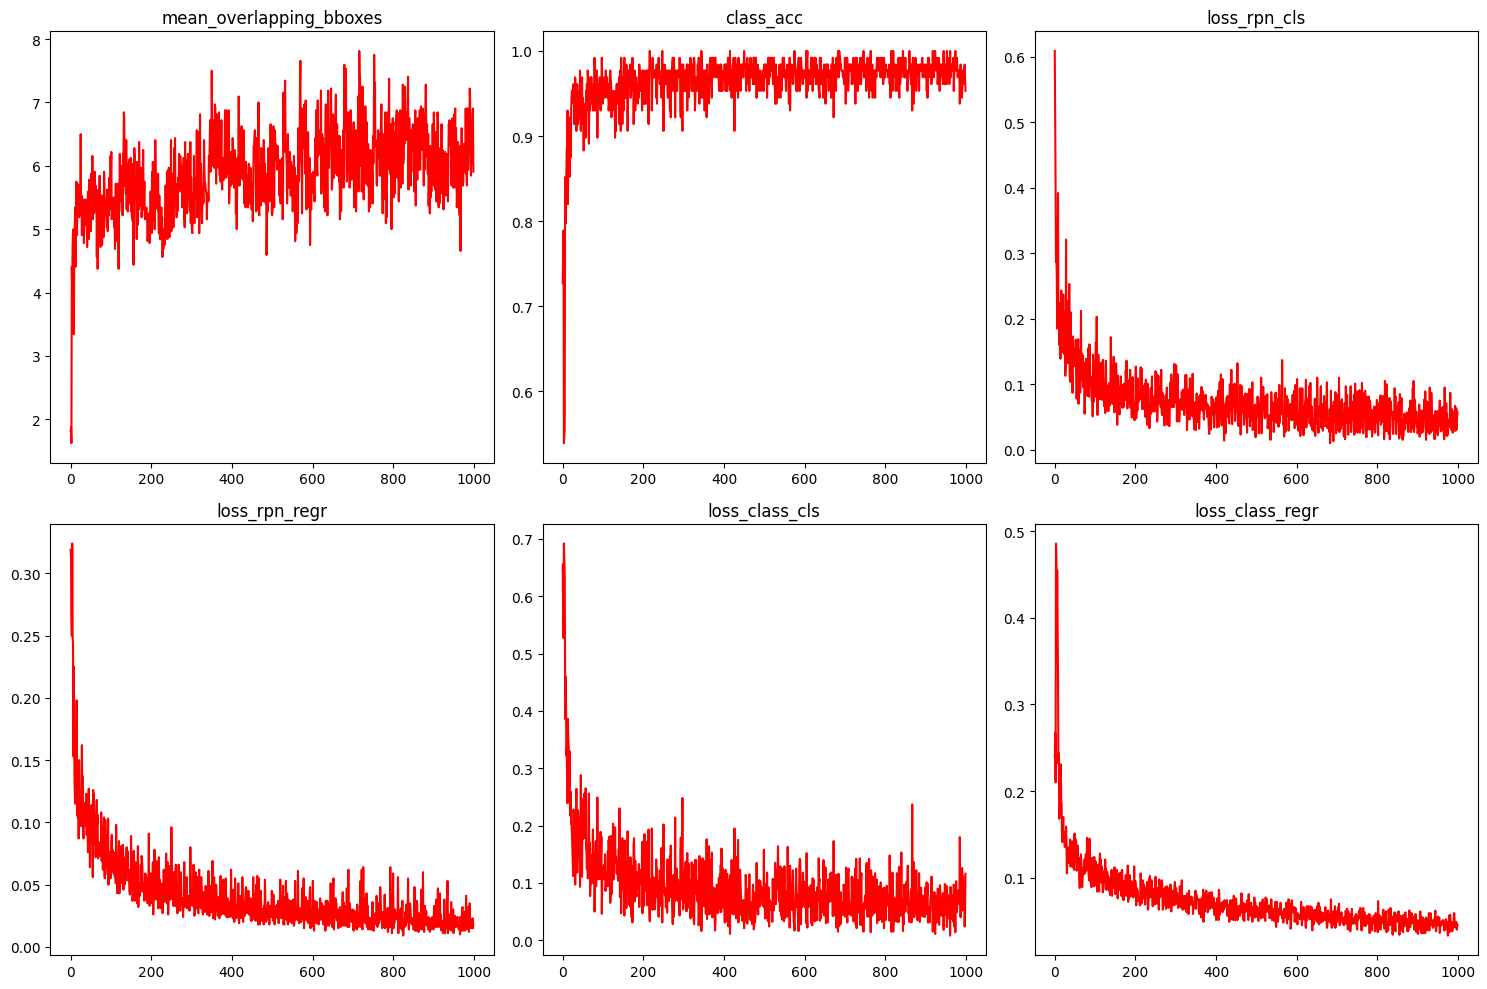

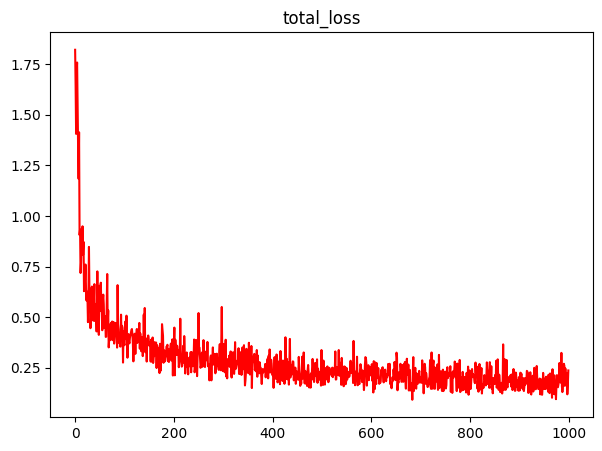

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Misalkan r_epochs adalah jumlah epoch yang direkam
r_epochs = len(record_df)

plt.figure(figsize=(15, 10))

# Plot mean_overlapping_bboxes
plt.subplot(2, 3, 1)
plt.plot(record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

# Plot class_acc
plt.subplot(2, 3, 2)
plt.plot(record_df['class_acc'], 'r')
plt.title('class_acc')

# Plot loss_rpn_cls 
plt.subplot(2, 3, 3)
plt.plot(record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

# Plot loss_rpn_regr
plt.subplot(2, 3, 4)
plt.plot(record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')

# Plot loss_class_cls
plt.subplot(2, 3, 5)
plt.plot(record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

# Plot loss_class_regr
plt.subplot(2, 3, 6)
plt.plot(record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')

plt.tight_layout()
plt.show()

# Plot total_loss
plt.figure(figsize=(7, 5))
plt.plot(record_df['curr_loss'], 'r')
plt.title('total_loss')
plt.show()
